# Чекпоинт 2. Разведочный анализ данных

## Подготовка окружения

Ссылка на Google Colab:

https://colab.research.google.com/drive/1Q6wqiG9TsQP3PS0eWjYQlS2IbgtzB5ab

In [ ]:
"""Google Colab"""
# надо устанаваливать в каждой сессии
!pip install pydicom
!pip install opencv-python
!pip install cleanvision  
# https://github.com/cleanlab/cleanvision
!pip install gdown

In [ ]:
import os
import zipfile
import gdown
from pathlib import Path
import pydicom
from PIL import Image
from IPython.display import display
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.preprocessing import LabelEncoder
from cleanvision import Imagelab

# """ cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash; """
# from google.colab.patches import cv2_imshow  # substitution/заменитель

' cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash; '

In [ ]:
DATA_DIR = 'data'

try:
  os.mkdir("mod_data")
  os.mkdir("mod_data/train_usual_format")
  os.mkdir("additionals") # one Ana image
except FileExistsError:
  print("Alredy Exists")

version="v1"

Alredy Exists


## Получение данных

In [ ]:
def fetch_data():
  """
  Download and unpack RSNA Pneumonia Detection dataset
  (https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge)
  """
  google_file_id = '1nIW5qgn4MurehHDiulrTMHNQMpsu4SRJ'
  zip_file_name = 'rsna-pneumonia-detection-challenge.zip'

  gdown.download(f'https://drive.google.com/uc?id={google_file_id}', zip_file_name, quiet=False)

  with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

  print("\nDone :)")

In [ ]:
fetch_data()  # Загрузка датасета

Downloading...
From (original): https://drive.google.com/uc?id=1nIW5qgn4MurehHDiulrTMHNQMpsu4SRJ
From (redirected): https://drive.google.com/uc?id=1nIW5qgn4MurehHDiulrTMHNQMpsu4SRJ&confirm=t&uuid=1140cf27-6d48-45ca-9be8-83ef9c582ae9
To: /content/rsna-pneumonia-detection-challenge.zip
100%|██████████| 3.93G/3.93G [00:33<00:00, 116MB/s]



Done :)


### Распаковка DICOM-файлов


In [ ]:
def extract_images(dir_names=['stage_2_test_images', 'stage_2_train_images']):
  """
  Extract and save .jpg images from DICOM files
  """
  for directory in dir_names:
    current_dir = Path(DATA_DIR) / directory
    jpg_dir = Path(DATA_DIR) / (directory + '_jpg')
    os.mkdir(jpg_dir)
    print(f'Extracting images from "{current_dir}" to "{jpg_dir}"')
    for filename in tqdm(os.listdir(current_dir)):
      stem, suffix = filename.split('.')
      if suffix == 'dcm':
        dcm_data = pydicom.dcmread(current_dir / filename)
        image = Image.fromarray(dcm_data.pixel_array)
        image.save(jpg_dir / (stem + '.jpg'))

In [ ]:
def extract_dicom_metadata(
    dir_name='stage_2_train_images',
    fields=["PatientID", "PatientSex", "PatientAge"]
    ):
  """
  Extract and save additional metadata from DICOM files to Pandas DataFrame
  """
  data = []
  current_dir = Path(DATA_DIR) / dir_name
  print('Extracting metadata from DICOM images')
  for filename in tqdm(os.listdir(current_dir)):
    if filename.endswith('dcm'):
      dcm_data = pydicom.dcmread(current_dir / filename)
      record = {}
      for field in fields:
          record[field] = dcm_data[field].value
      data.append(record)

  df = pd.DataFrame(data)
  return df

In [ ]:
# Извлечение изображений из DICOM в отдельные папки
extract_images()

# Извлечение полезных атрибутов из DICOM в pd.DataFrame
dcm_meta = extract_dicom_metadata(fields=["PatientID", "PatientSex", "PatientAge"])

# Исправление типов данных
dcm_meta['PatientAge'] = dcm_meta['PatientAge'].astype('int64')

# Read Datasets
labels = pd.read_csv('data/stage_2_train_labels.csv')
class_info = pd.read_csv('data/stage_2_detailed_class_info.csv')

print("""
\nDataFrames created:
  - labels: PatientID and target variable
  - class_info: PatientID and detailed class description
  - dcm_meta: PatientID and additional DICOM metadata
""")

Extracting images from "data/stage_2_test_images" to "data/stage_2_test_images_jpg"


100%|██████████| 3000/3000 [00:44<00:00, 67.38it/s]


Extracting images from "data/stage_2_train_images" to "data/stage_2_train_images_jpg"


100%|██████████| 26684/26684 [05:54<00:00, 75.37it/s]


Extracting metadata from DICOM images


100%|██████████| 26684/26684 [00:46<00:00, 569.48it/s] 




DataFrames created:
  - labels: PatientID and target variable
  - class_info: PatientID and detailed class description
  - dcm_meta: PatientID and additional DICOM metadata



## Разведочный анализ данных




### Таблица `labels`

The training data is provided as a set of patientIds and bounding boxes.

Bounding boxes are defined as follows:
* x
* y
* width
* height

Target is **"1" or "0"**. It means has or not box. If it "0", there are can be something wrong, but no opacity, and no box.*Курсив*

In [ ]:
labels.iloc[6:11]

,patientId,x,y,width,height,Target
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
10,008c19e8-a820-403a-930a-bc74a4053664,NaN,NaN,NaN,NaN,0


Полных дублей нет

In [ ]:
print(f"Dataset size: {labels.shape}")
print(f"Размер после удаления дублей:{labels.drop_duplicates().shape}")

Dataset size: (30227, 6)
Размер после удаления дублей:(30227, 6)


У каких-то пациентов по несколько боксов

In [ ]:
print(f"Кол-во пациентов: {labels.patientId.nunique()}")

Кол-во пациентов: 26684


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
labels.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


#### Дизбаланс классов


In [ ]:
print("Target (Наличие или отсутствие бокса):", labels.Target.unique())

Target (Наличие или отсутствие бокса): [0 1]


In [ ]:
labels.shape[0]

30227

In [ ]:
labels[labels["Target"] == 1].shape[0]

9555

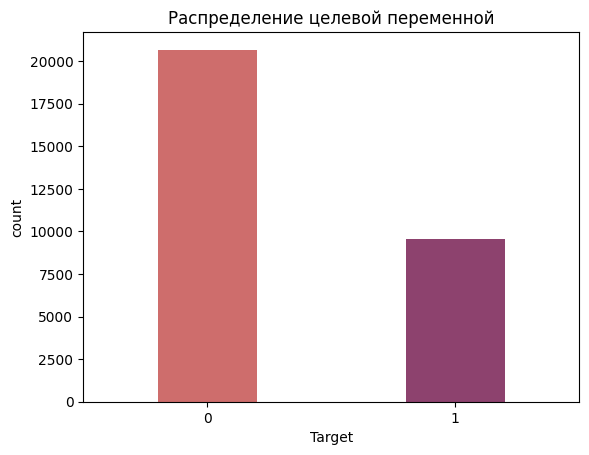

In [11]:
sns.countplot(
    labels, 
    x='Target', 
    hue='Target', 
    legend=False, 
    palette='flare', 
    width=0.4
    ).set(title="Распределение целевой переменной");  

### Таблица `detailed_class_info`

detailed_class_info - contains detailed information about the positive and negative classes in the training set

In [ ]:
class_info.head(4)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal


У нас есть полные дубликаты

In [ ]:
print("Уникальных пациентов:", class_info["patientId"].nunique())
print("Строк в датасете:", class_info.shape[0])

Уникальных пациентов: 26684
Строк в датасете: 30227


In [ ]:
class_info = class_info.drop_duplicates()
class_info.shape[0]

26684

In [ ]:
class_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26684 entries, 0 to 30225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   class      26684 non-null  object
dtypes: object(2)
memory usage: 625.4+ KB


In [ ]:
class_info.describe(include='object')

,patientId,class
count,26684,26684
unique,26684,3
top,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
freq,1,11821


In [ ]:
print("Детальные классы:", class_info["class"].unique())

Детальные классы: ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


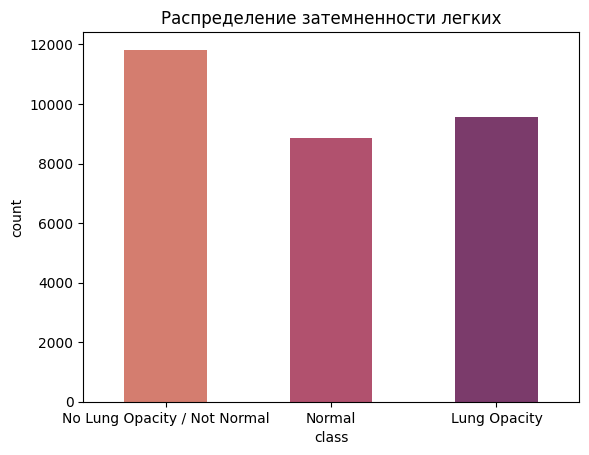

In [16]:
sns.countplot(class_info, x='class', hue='class', legend=False, palette='flare', width=0.5).set(title="Распределение затемненности легких"); # Ana maked from Vanya

#### Модификация **detailed_class_info**

In [ ]:
le = LabelEncoder()
le.fit_transform(class_info["class"])

array([1, 1, 1, ..., 2, 2, 0])

In [ ]:
class_info["enc_class"] = le.fit_transform(class_info["class"])

In [ ]:
class_info.to_csv(f'mod_data/class_details_{version}.csv', index=False)
class_info.head()

,patientId,class,enc_class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,2
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,0



|Label|Text Label|Desc|
|:-|:-|:-|
|0|Lung Opacity|Есть затемнение в лёгких, есть bounding box|
|1|No Lung Opacity / Not Normal|Нет затемнения в лёгких, нет bounding box, но есть патология|
|2|Normal|Здоровые лёгкие|

### Таблица метаданных из DICOM 

In [ ]:
dcm_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PatientID   26684 non-null  object
 1   PatientSex  26684 non-null  object
 2   PatientAge  26684 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 625.5+ KB


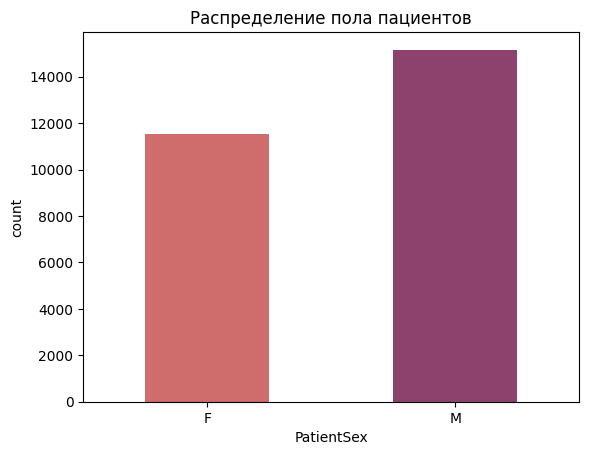

In [ ]:
sns.countplot(dcm_meta, x='PatientSex', hue='PatientSex', legend=False, palette='flare', width=0.5).set(title='Распределение пола пациентов');  # Vanya + Ana added "width"

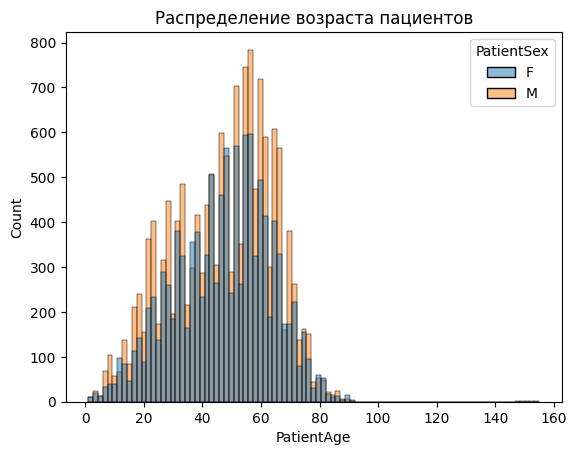

In [ ]:
sns.histplot(dcm_meta, x='PatientAge', hue='PatientSex').set(title='Распределение возраста пациентов');  # Vanya

## Поиск ошибок в файлах
(Ana)

* файлов 26684 шт., все файлы нормально считываются
* все файлы имеют поле PatientId
* название файла всгда соответсвует полю PatientId + ".dcm"

## Сколько у нас боксов
(Ana)

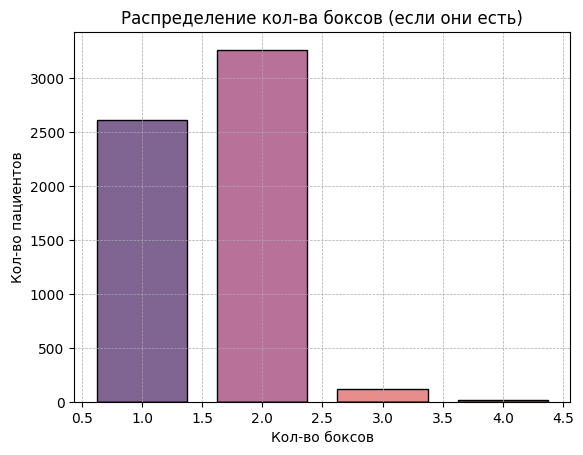

In [40]:
train_labels = pd.read_csv("data/stage_2_train_labels.csv")
boxes_per_patient = pd.DataFrame(train_labels.patientId[train_labels.Target == 1].value_counts()).reset_index()

ax = sns.histplot(boxes_per_patient, x='count', hue='count', discrete=True, shrink=0.75, palette="flare_r", legend=False, alpha=0.7)

plt.title("Распределение кол-ва боксов (если они есть)")
plt.xlabel("Кол-во боксов")
plt.ylabel("Кол-во пациентов")
ax.grid(True, linestyle='--', linewidth=0.5, color="#aaaaaa");

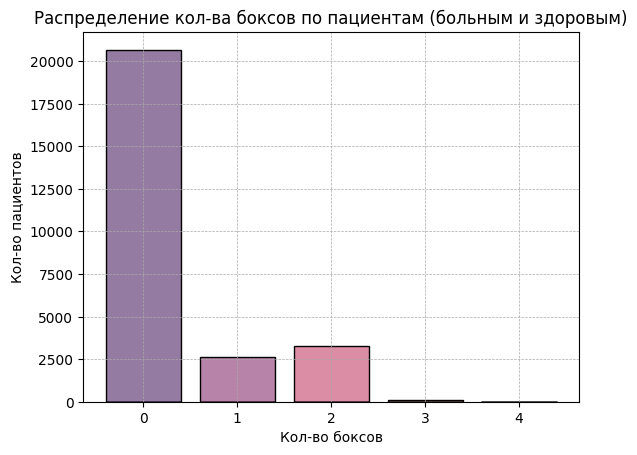

In [ ]:
no_boxes = pd.DataFrame(train_labels[train_labels.Target == 0].patientId)
no_boxes["count"] = 0

boxes_per_patient = pd.concat([boxes_per_patient, no_boxes], ignore_index=True)

ax = sns.histplot(boxes_per_patient, x='count', hue='count', discrete=True, shrink=0.8, palette="flare_r", legend=False, alpha=0.7)

plt.title("Распределение кол-ва боксов по пациентам (больным и здоровым)")
plt.xlabel("Кол-во боксов")
plt.ylabel("Кол-во пациентов")
ax.grid(True, linestyle='--', linewidth=0.5, color="#aaaaaa");

In [ ]:
pd.DataFrame(boxes_per_patient["count"].value_counts()).rename(columns={"count":"patients_amount"}).reset_index().sort_values(by="count")

,count,patients_amount
0,0,20672
2,1,2614
1,2,3266
3,3,119
4,4,13


## Отрисовка изображений и Bonding Box'ов
Ana + Ivan

In [ ]:
def show_image(filename: str, draw_box=True) -> None:
    """
    Ana Version -- cv2
    Show one image by name of file or PatienId
    with or without Bounding box(es)
    No scribes

    Args:
        filename (str): File name or PatienId
        draw_box (bool, optional): Draw or not Bounding box

    Returns:
        None
    """

    # Check extention in filename
    if not ".dcm" in filename:
        filename += ".dcm"

    # Get path to image
    filepath = f"data/stage_2_train_images/{filename}"

    # Read .dcm
    dcm_file = pydicom.dcmread(filepath)
    pixel_array = dcm_file.pixel_array
    image = np.array(pixel_array, dtype=np.uint8)

    # Trying draw box(es)
    if (draw_box) and ("PatientID" in dcm_file):
        patient_id = dcm_file.PatientID
        df = pd.read_csv("data/stage_2_train_labels.csv")  # df with box(es)
        patient = df[df["patientId"] == patient_id]

        for _, row in patient.iterrows():
          if not np.sum(row[["x", "y", "width", "height"]].isna()):
              x, y, w, h = map(lambda x: int(x), row[["x", "y", "width", "height"]])
              start_point = (x, y)  # left top
              end_point = (x+w, y+h) # right bottom
              color = (0, 255, 0)
              thickness = 2
              cv2.rectangle(image, start_point, end_point, color, thickness)

    # Show image
    # cv2.imshow('DICOM Image', image)
    cv2_imshow(image)  # google colab substitute
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return None

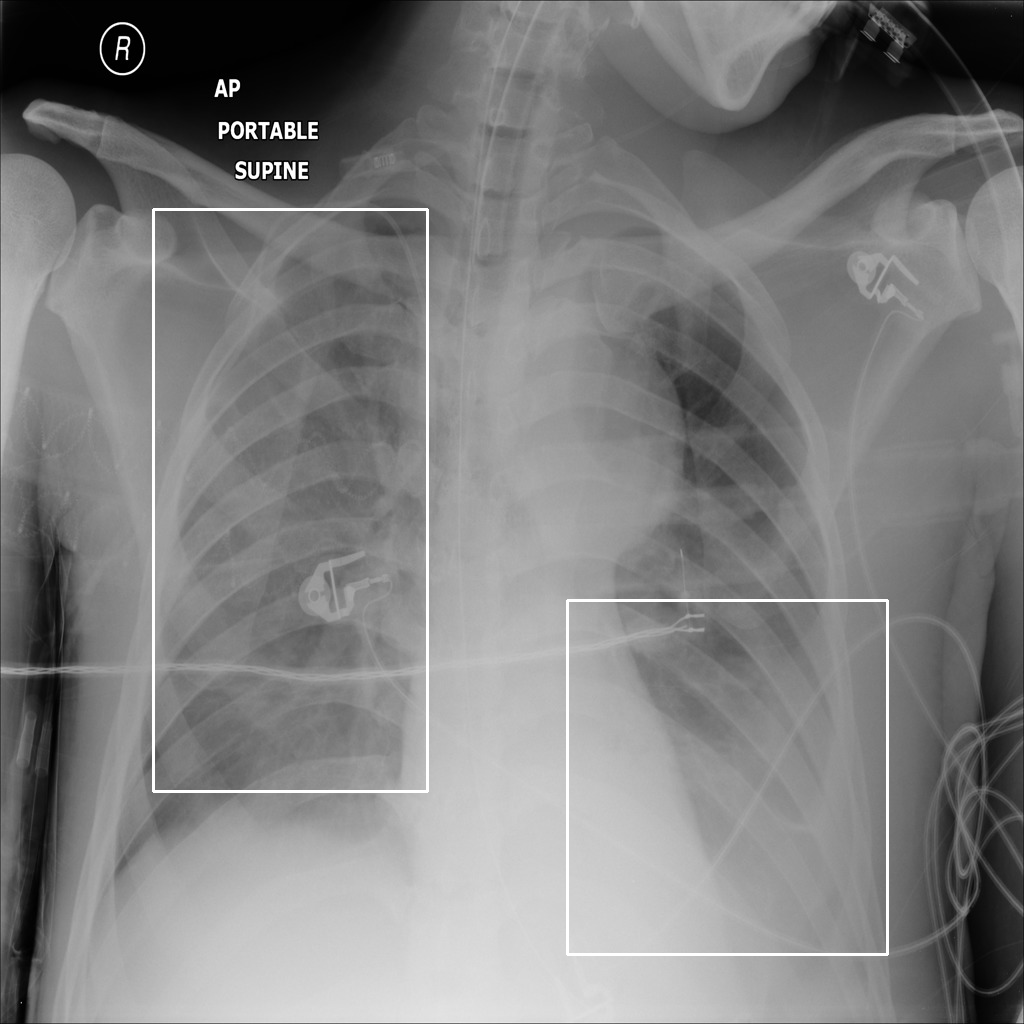

In [ ]:
# пример есть 2 бокса
show_image("09852193-d7df-4cce-a616-a536d5de5042")

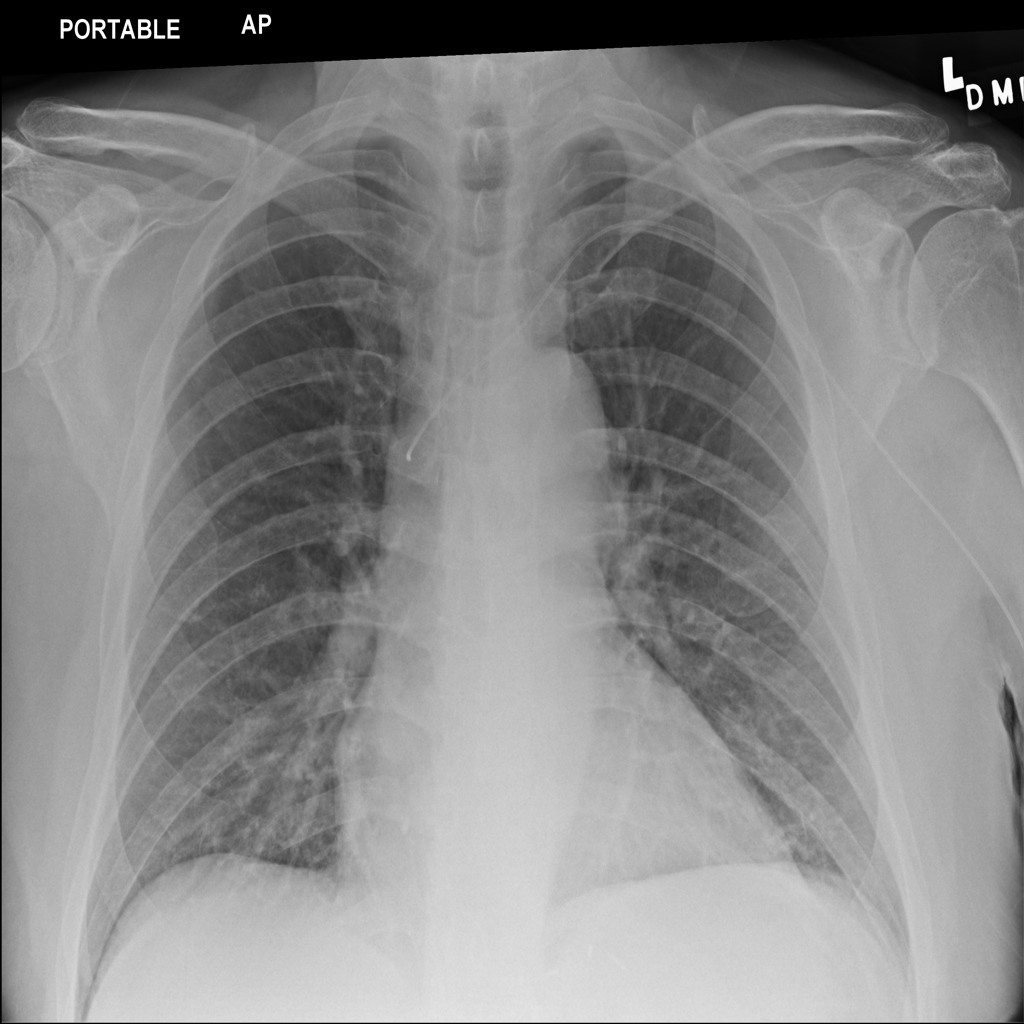

In [ ]:
# пример нет бокса: прикол не должно сломаться
show_image("0a5a6574-d94d-441f-afe4-115ba66b322e.dcm")

In [ ]:
def show_image(patient_id='00436515-870c-4b36-a041-de91049b9ab4', with_bbox=True):
  """
  Ivan Version -- matplotlib
  Display an image from training set
  """
  dicom = pydicom.dcmread(Path(DATA_DIR) / 'stage_2_train_images' / (patient_id + '.dcm'))
  plt.imshow(dicom.pixel_array, cmap='binary')
  plt.axis('off')

  df = labels[(labels.patientId == patient_id) & (labels.Target == 1)]
  if df.shape[0] > 0:
      for index, row in df.iterrows():
          x = row['x']
          y = row['y']
          width = row['width']
          height = row['height']

          rect = plt.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
          plt.gca().add_patch(rect)

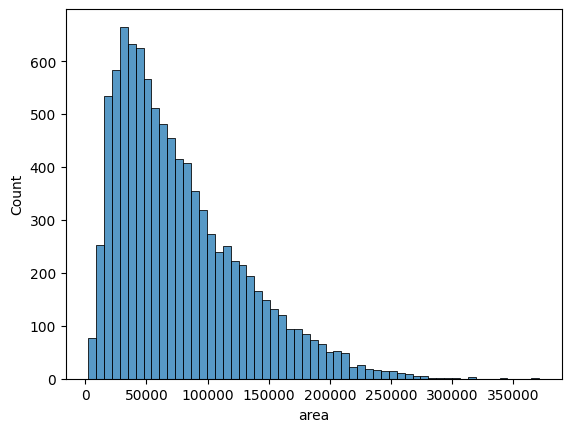

In [ ]:
# распределение размеров bounding box'ов
labels = pd.read_csv('data/stage_2_train_labels.csv')
labels['area'] = labels['width'] * labels['height']
sns.histplot(labels, x='area');

In [ ]:
max_bbox_area_pId = labels.sort_values(['area'], ascending=False).iloc[0, 0]
min_bbox_area_pId = labels.sort_values(['area']).iloc[0, 0]

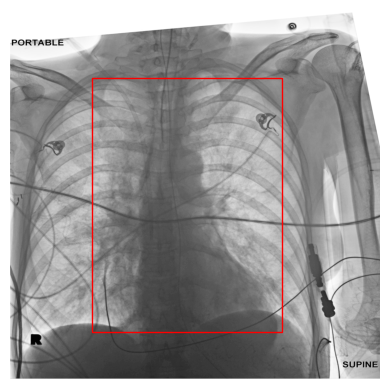

In [ ]:
show_image(max_bbox_area_pId);  # Изображение с bounding box'ом максимального размера

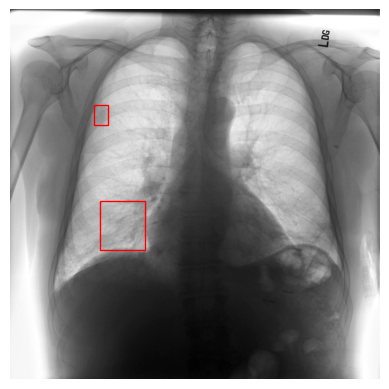

In [ ]:
show_image(min_bbox_area_pId);  # Изображение с bounding box'ом минимального размера

Нарисуем все баундин боксы на одной картинке

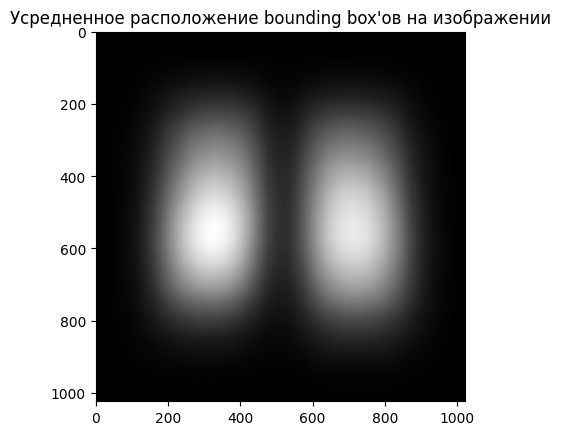

In [ ]:
"""Vanya"""
# Оставляем в DataFrame только записи с bounding box'ами
df = labels[(labels.Target == 1)]

# Создаем пустое изображение  1024x1024
img = np.zeros((1024, 1024))

for _, row in df.iterrows():
    # Последовательно считываем координаты bounding box'ов
    x = row['x']
    y = row['y']
    width = row['width']
    height = row['height']

    # Увеличиваем значение пикселей, попавших в текущий bounding box
    img[int(y):int(y + height), int(x):int(x + width)] += 1

# Отображаем получившуюся тепловую карту
plt.imshow(img, cmap='gray')
plt.title("Усредненное расположение bounding box'ов на изображении")
plt.show()

In [ ]:
"""Nastya"""

# def draw_all_boxes(thickness=1, alpha=0.005) -> None:
#     """
#     Draw all boxes in black image
#     with big transparency
#     Подход: просто рисовать боксы c высокой прозрачностью и восхищаться ЦПТ

#     alpha - чем больше, тем ярче
#     """

#     back = np.zeros((1024, 1024, 3))

#     train_labels = pd.read_csv("data/stage_2_train_labels.csv")
#     train_labels = train_labels[train_labels.Target == 1]
#     train_labels = train_labels.drop_duplicates()

#     for _, row in train_labels.iterrows():
#         x, y, w, h = map(lambda x: int(x), row[["x", "y", "width", "height"]])
#         left_top = (x, y)
#         right_bottom = (x+w, y+h)
#         color = (0, 10, 0)

#         overlay = back.copy()
#         cv2.rectangle(overlay, left_top, right_bottom, color, thickness)
#         cv2.addWeighted(overlay, alpha, back, 1 - alpha, 0, back)

#     cv2.imshow("name", back)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

#     return None

In [ ]:
google_file_id = '18FhGb9m9-C8p5C5a4Zp5IzEJ6-hEiwB6'
file_name = 'additionals/name_screenshot.png'

gdown.download(f'https://drive.google.com/uc?id={google_file_id}', file_name, quiet=True)

import matplotlib.image as im
img = im.imread(file_name)

**thickness=1, alpha=0.005 (Ana Locally)**

Already created


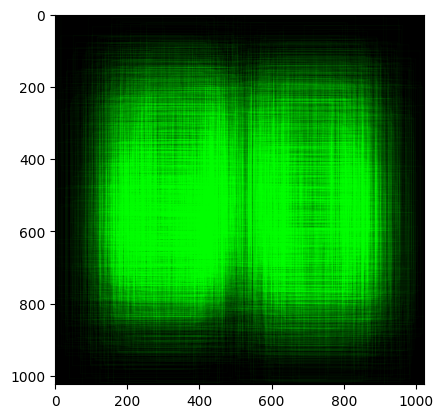

In [ ]:
plt.imshow(img)

* Вырисовываются лёгкие при закрашенных bounding box(ах) и при отрисовке рамками
* Получается, что боксы возникают по всем лёгким
* Границы боксов чаще возникают, на границах правой и левой частей лёгких
* Очередной раз показано, что ЦПТ работает
* (1) + (2) - вверху пневмония встречается реже
* (1) + (2) - (в левом для нас/ в правом) лёгком боксы возникают чаще, + там размер боксов меньше (мне так кажется)

Вариабельность размеров: <p>Все изображения **1024x1024** (Ana)

In [ ]:
# тоже самое было сделано со всеми
filepath = f"data/stage_2_train_images/0a5a6574-d94d-441f-afe4-115ba66b322e.dcm"

dcm_file = pydicom.dcmread(filepath)
pixel_array = dcm_file.pixel_array
image = np.array(pixel_array, dtype=np.uint8)

image.shape

(1024, 1024)

Доверяй, но проверяй

## Поиск ошибок в датасете с помощью библиотеки Clean Vision





In [ ]:
dataset_path = 'data/stage_2_train_images_jpg'

imagelab = Imagelab(data_path=dataset_path)

imagelab.find_issues()

Reading images from /content/data/stage_2_train_images_jpg
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/26684 [00:00<?, ?it/s]

  0%|          | 0/26684 [00:00<?, ?it/s]

Issue checks completed. 29088 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


Removing grayscale from potential issues in the dataset as it exceeds max_prevalence=0.5 
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  1 | blurry           |         2398 |
|  2 | exact_duplicates |            2 |
|  3 | near_duplicates  |            2 |
|  4 | dark             |            1 |
|  5 | low_information  |            1 |
|  6 | light            |            0 |
|  7 | odd_aspect_ratio |            0 |
|  8 | odd_size         |            0 | 

---------------------- blurry images -----------------------

Number of examples with this issue: 2398
Examples representing most severe instances of this issue:



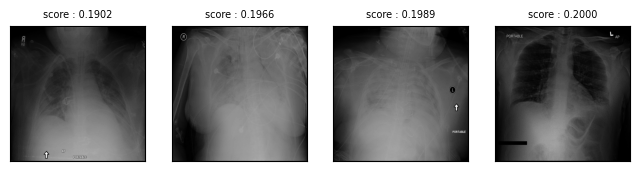

----------------- exact_duplicates images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:

Set: 0


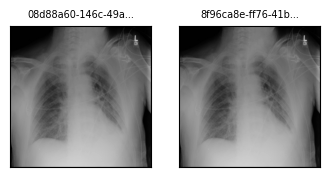

------------------ near_duplicates images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:

Set: 0


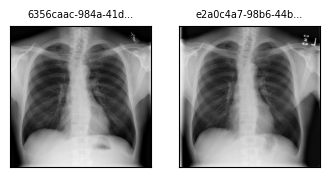

----------------------- dark images ------------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



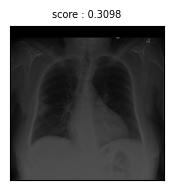

------------------ low_information images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



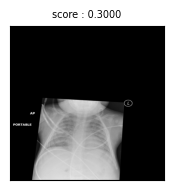

In [ ]:
imagelab.report()

* есть размытые изображения, новые данные на вход модели тоже могут быть размытыми
* у нас есть 1 плохо засвеченное изображение
* у нас есть 2 дубля (2 пары)
* low_information images - выглядит как ребёнок, сам рентгеновский сникомок может быть маленького размера